In [35]:
# @title Importing modules
import pandas as pd
import numpy as np
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score , confusion_matrix, precision_score, recall_score, f1_score , cohen_kappa_score
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import optimizers


In [2]:
# @title Define labels and our dataframe
data = pd.DataFrame(columns=['image_path', 'label'])

labels = {'/kaggle/input/satellite-image-classification/data/cloudy' : 'Cloudy',
          '/kaggle/input/satellite-image-classification/data/desert' : 'Desert',
          '/kaggle/input/satellite-image-classification/data/green_area' : 'Green_Area',
          '/kaggle/input/satellite-image-classification/data/water' : 'Water',
           }

In [3]:
# @title To append the data into the dataframe with our labels and paths

for folder in labels:
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        label = labels[folder]
        data = pd.concat([data, pd.DataFrame({'image_path': [image_path], 'label': [label]})], ignore_index=True)

In [5]:
# @title Create the csv file with our data

# path = '/kaggle/input/satellite-image-classification/data/'
# if Path(path).is_dir():
#     path = Path(path).joinpath()
# print(path)
data.to_csv('dataSet.csv', index=False)

In [7]:
# @title Read our CSV file

df = pd.read_csv("/kaggle/working/dataSet.csv")
print(df)

                                             image_path   label
0     /kaggle/input/satellite-image-classification/d...  Cloudy
1     /kaggle/input/satellite-image-classification/d...  Cloudy
2     /kaggle/input/satellite-image-classification/d...  Cloudy
3     /kaggle/input/satellite-image-classification/d...  Cloudy
4     /kaggle/input/satellite-image-classification/d...  Cloudy
...                                                 ...     ...
5626  /kaggle/input/satellite-image-classification/d...   Water
5627  /kaggle/input/satellite-image-classification/d...   Water
5628  /kaggle/input/satellite-image-classification/d...   Water
5629  /kaggle/input/satellite-image-classification/d...   Water
5630  /kaggle/input/satellite-image-classification/d...   Water

[5631 rows x 2 columns]


In [8]:
# @title Cross-validation, and finding the best deployable model

# Define the number of folds for cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Track best hyperparameters and performance
best_accuracy = 0.0
best_model = None
best_history = None

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(skf.split(df['image_path'], df['label']), start = 1):
    print(f"Fold {fold}/{n_splits}")

    # Split the data into training and testing sets for this fold
    train_df, test_df = df.iloc[train_index], df.iloc[test_index]

    # the rescale is done to make the training faster if each pixel of each image is
    # normalized to be between 0 and 1 ans it's no need to normalize it between -1 and 1
    train_datagen = ImageDataGenerator(rescale=1./255,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      rotation_range=45,
                                      vertical_flip=True,
                                      fill_mode='nearest')

    #here no need to do anything more than just rescaling
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                        x_col="image_path",
                                                        y_col="label",
                                                        target_size=(255, 255),
                                                        batch_size=32,
                                                        class_mode="categorical")

    test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                      x_col="image_path",
                                                      y_col="label",
                                                      target_size=(255, 255),
                                                      batch_size=32,
                                                      class_mode="categorical")
    #Creating our model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(255, 255, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax'))

    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # print("Number of samples in train_generator:", len(train_generator))
    # print("Number of samples in train_df['label']:", len(train_df['label']))
    history = model.fit(train_generator, epochs=50, validation_data=test_generator, callbacks=[early_stopping])

    # Evaluate the model on the test set for this fold
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy for Fold {fold}: {test_accuracy}")

    # Check if this fold had the best performance
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model  # Save the model with the best performance
        best_history = history  # Save the history of the best fold


Fold 1/5
Found 4504 validated image filenames belonging to 4 classes.
Found 1127 validated image filenames belonging to 4 classes.
Epoch 1/50
141/141 [==============================] - 128s 850ms/step - loss: 0.6204 - accuracy: 0.6801 - val_loss: 0.4899 - val_accuracy: 0.7906
Epoch 2/50
141/141 [==============================] - 88s 627ms/step - loss: 0.4207 - accuracy: 0.8306 - val_loss: 0.3468 - val_accuracy: 0.8660
Epoch 3/50
141/141 [==============================] - 87s 614ms/step - loss: 0.3707 - accuracy: 0.8512 - val_loss: 0.2893 - val_accuracy: 0.8926
Epoch 4/50
141/141 [==============================] - 89s 629ms/step - loss: 0.3370 - accuracy: 0.8683 - val_loss: 0.2854 - val_accuracy: 0.8935
Epoch 5/50
141/141 [==============================] - 84s 592ms/step - loss: 0.3257 - accuracy: 0.8621 - val_loss: 0.4708 - val_accuracy: 0.6770
Epoch 6/50
141/141 [==============================] - 88s 621ms/step - loss: 0.3912 - accuracy: 0.8282 - val_loss: 0.3018 - val_accuracy: 0.892

In [9]:
best_accuracy

0.9218472242355347

In [36]:
# Split the whole dataset into training and testing sets
final_train_df, final_test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define the ImageDataGenerator for the training dataset
final_train_datagen = ImageDataGenerator(rescale=1./255,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         rotation_range=45,
                                         vertical_flip=True,
                                         fill_mode='nearest')

# Define the ImageDataGenerator for the testing dataset
final_test_datagen = ImageDataGenerator(rescale=1./255)

# Create the full dataset generator to be used with the best model after cross-validation
final_train_dataset_generator = final_train_datagen.flow_from_dataframe(dataframe=final_train_df,
                                                                  x_col="image_path",
                                                                  y_col="label",
                                                                  target_size=(255, 255),
                                                                  batch_size=128,
                                                                  class_mode="categorical")


final_test_dataset_generator = final_test_datagen.flow_from_dataframe(dataframe=final_test_df,
                                                  x_col="image_path",
                                                  y_col="label",
                                                  target_size=(255, 255),
                                                  batch_size=128,
                                                  class_mode="categorical")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Found 4504 validated image filenames belonging to 4 classes.
Found 1127 validated image filenames belonging to 4 classes.


In [38]:
# Train the best model on the entire dataset

best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
final_history = best_model.fit(final_train_dataset_generator, epochs=50, validation_data=final_test_dataset_generator, callbacks=[reduce_lr,early_stopping])

Epoch 1/50
36/36 [==============================] - 96s 3s/step - loss: 0.1027 - accuracy: 0.9698 - val_loss: 0.0826 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 2/50
36/36 [==============================] - 71s 2s/step - loss: 0.1225 - accuracy: 0.9634 - val_loss: 0.1478 - val_accuracy: 0.9503 - lr: 0.0010
Epoch 3/50
36/36 [==============================] - 71s 2s/step - loss: 0.0840 - accuracy: 0.9754 - val_loss: 0.0572 - val_accuracy: 0.9823 - lr: 0.0010
Epoch 4/50
36/36 [==============================] - 74s 2s/step - loss: 0.0619 - accuracy: 0.9778 - val_loss: 0.0594 - val_accuracy: 0.9814 - lr: 0.0010
Epoch 5/50
36/36 [==============================] - 72s 2s/step - loss: 0.0615 - accuracy: 0.9805 - val_loss: 0.0724 - val_accuracy: 0.9743 - lr: 0.0010
Epoch 6/50
36/36 [==============================] - 72s 2s/step - loss: 0.0507 - accuracy: 0.9831 - val_loss: 0.0533 - val_accuracy: 0.9831 - lr: 1.0000e-04
Epoch 7/50
36/36 [==============================] - 72s 2s/step - loss: 0.0440

In [39]:
# @title Save the model as h5 file
# Save the best model for deployment
best_model.save('/kaggle/working/deployable_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
#Use only to delete the deployable model in the working directory in Kaggle
os.remove("/kaggle/working/deployable_model.h5")

In [55]:
print("Loss function:", best_model.loss)
print("Optimizer:", best_model.optimizer)
print("Metrics:", best_model.metrics_names)

Loss function: categorical_crossentropy
Optimizer: <keras.src.optimizers.adam.Adam object at 0x7c7c443f5480>
Metrics: ['loss', 'accuracy']


In [40]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 253, 253, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 251, 251, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 125, 125, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 123, 123, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 59, 59, 128)      

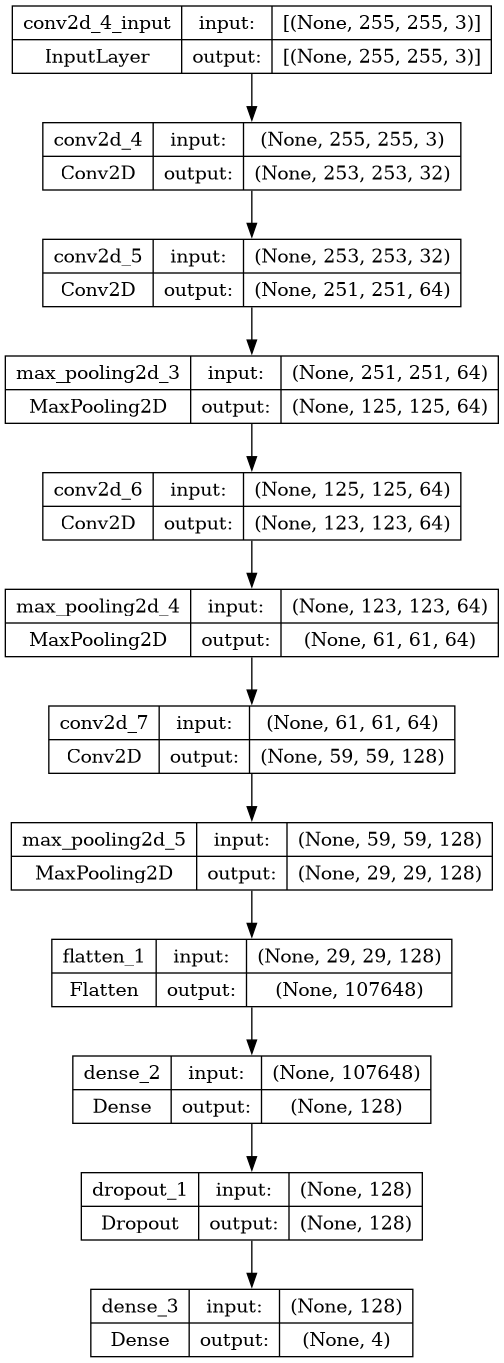

In [41]:
from tensorflow.keras.utils import plot_model
from PIL import Image

plot_model(best_model, to_file='/kaggle/working/cnn_model.png', show_shapes=True, show_layer_names=True)
display(Image.open('/kaggle/working/cnn_model.png'))

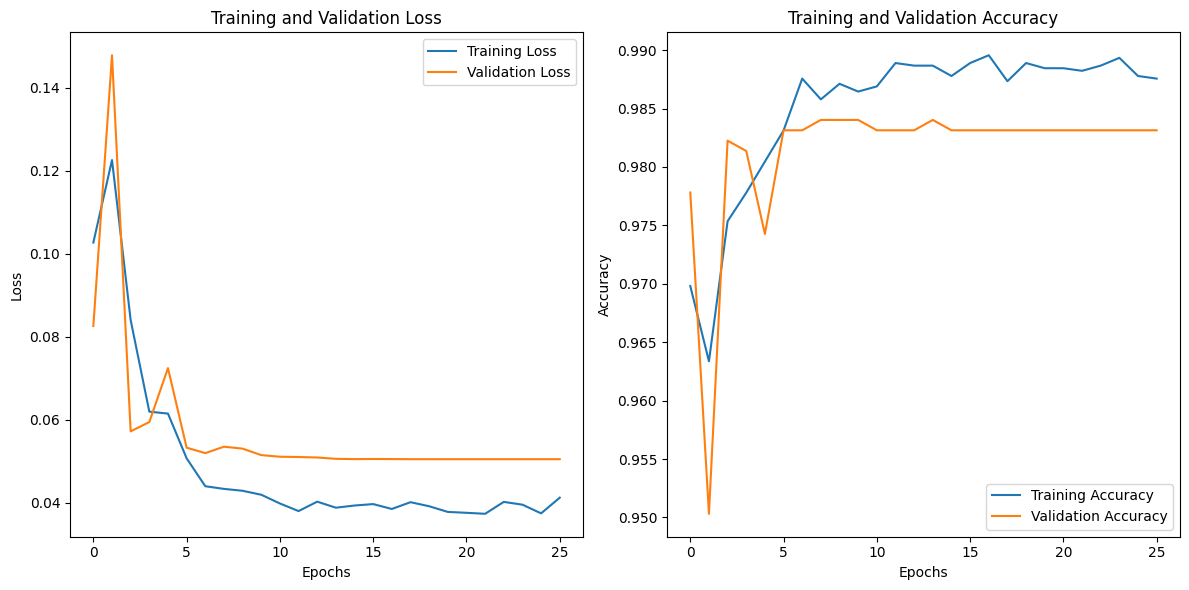

In [42]:
# @title Loss & Accuracy Visualizations
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the loss
ax1.plot(final_history.history['loss'], label='Training Loss')
ax1.plot(final_history.history['val_loss'], label='Validation Loss')
ax1.legend()
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

# Plot the accuracy
ax2.plot(final_history.history['accuracy'], label='Training Accuracy')
ax2.plot(final_history.history['val_accuracy'], label='Validation Accuracy')
ax2.legend()
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

# Adjust layout and show the plots
plt.tight_layout()

# Save the figures in the working directory
plt.savefig('LossVal_loss.png')
plt.savefig('AccVal_acc.png')

# Show the plots
plt.show()

In [43]:
# @title Load model

model = load_model("/kaggle/working/deployable_model.h5")

In [44]:
#Importing libraries needed for confusion matrix

from sklearn.metrics import confusion_matrix
import numpy as np

In [46]:
#Store our model's predictions when tested against the test_generator dataset

predictions = model.predict_generator(test_generator)
predictions

/tmp/ipykernel_42/4127305638.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


array([[1.0290674e-36, 0.0000000e+00, 1.0000000e+00, 7.7705466e-19],
       [4.0222845e-29, 0.0000000e+00, 2.2325560e-21, 1.0000000e+00],
       [1.0693214e-15, 3.3217579e-35, 1.1389905e-11, 1.0000000e+00],
       ...,
       [2.8930733e-10, 1.0000000e+00, 0.0000000e+00, 1.8518676e-32],
       [2.9519468e-25, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.6160620e-12, 0.0000000e+00, 9.9991500e-01, 8.4955849e-05]],
      dtype=float32)

In [48]:
#test_generator.classes returns the true labels given to the samples in the test_generator

actual_labels = test_generator.classes

In [49]:
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

array([2, 3, 3, ..., 1, 1, 2])

In [54]:
#Generate the confusion matrix array

cm = confusion_matrix(actual_labels, predicted_labels)
cm

array([[76, 49, 85, 90],
       [60, 50, 51, 65],
       [88, 60, 77, 75],
       [77, 64, 88, 71]])

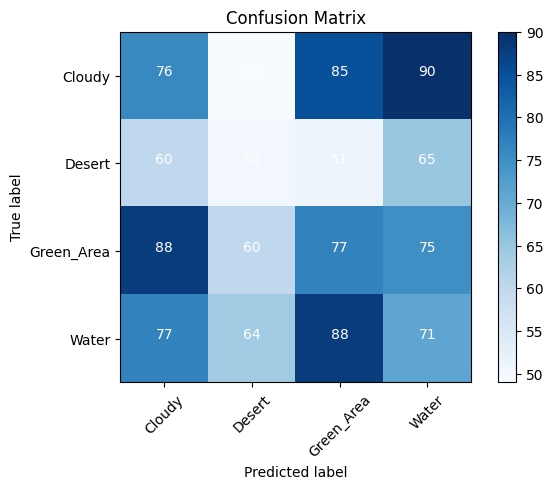

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Define the class names
class_names = ['Cloudy', 'Desert', 'Green_Area', 'Water']


# Confusion matrix

# Plot the confusion matrix as an image
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Add the class labels to the plot
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Add values to the plot
threshold = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black")

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.savefig('Confusion Matrix')
plt.show()